# Conjunto de dados para classificação de satisfação de clientes de companhias aéreas

## Problema

O conjunto de dados consiste na predição de satisfação de clientes de uma companhia aérea baseado em algumas caracteristicas físicas, profissional e da viagem do cliente.

Trata-se de um problema de classificação binario.

_Features_
- Gender: Sexo do passageiro (Female/Male).
- Age: Idade do passageiro (Natural).
- Customer Type: Tipo do cliente (First-time/Returning).
- Type of Travel: Propossito da viagem (Business/Personal).
- Class: Classe do assento do passgeiro no avião (Bussiness, Economic, Economic Plus).
- Flight Distance: Distância do voou em milhas.
- Departure Delay: Atraso de partida do voou, em minutos.
- Arrival Delay: Atraso na chegada do voou, em minutos.
- Departure and Arrival Time Convenience: "Satisfaction level with the convenience of the flight departure and arrival times from 1 (lowest) to 5 (highest) - 0 means ""not applicable"""
- Ease of Online Booking: "Satisfaction level with the online booking experience from 1 (lowest) to 5 (highest) - 0 means ""not applicable"""
- Check-in Service: "Satisfaction level with the check-in service from 1 (lowest) to 5 (highest) - 0 means ""not applicable"""
- Online Boarding: "Satisfaction level with the online boarding experience from 1 (lowest) to 5 (highest) - 0 means ""not applicable"""
- Gate Location: "Satisfaction level with the gate location in the airport from 1 (lowest) to 5 (highest) - 0 means ""not applicable"""
- On-board Service: "Satisfaction level with the on-boarding service in the airport from 1 (lowest) to 5 (highest) - 0 means ""not applicable"""
- Seat Comfort: "Satisfaction level with the comfort of the airplane seat from 1 (lowest) to 5 (highest) - 0 means ""not applicable"""
- Leg Room Service: "Satisfaction level with the leg room of the airplane seat from 1 (lowest) to 5 (highest) - 0 means ""not applicable"""
- Cleanliness: "Satisfaction level with the cleanliness of the airplane from 1 (lowest) to 5 (highest) - 0 means ""not applicable"""
- Food and Drink: "Satisfaction level with the food and drinks on the airplane from 1 (lowest) to 5 (highest) - 0 means ""not applicable"""
- In-flight Service: "Satisfaction level with the in-flight service from 1 (lowest) to 5 (highest) - 0 means ""not applicable"""
- In-flight Wifi Service: "Satisfaction level with the in-flight Wifi service from 1 (lowest) to 5 (highest) - 0 means ""not applicable"""
- In-flight Entertainment: "Satisfaction level with the in-flight entertainment from 1 (lowest) to 5 (highest) - 0 means ""not applicable"""
- Baggage Handling: "Satisfaction level with the baggage handling from the airline from 1 (lowest) to 5 (highest) - 0 means ""not applicable"""
- Satisfaction: Nivel de satisfação com a companhia aérea (Satisfied/Neutral or unsatisfied)


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from copy import copy
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,RandomizedSearchCV
from sklearn.metrics import f1_score,classification_report
from sklearn import ensemble
from sklearn import svm

## Importando dataset

In [4]:
df = pd.read_csv('../datasets/airline_passenger_satisfaction.csv').drop('ID',axis=1)

## Apresentação dos dados

In [5]:
df.head()

,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,Male,48,First-time,Business,Business,821,2,5.0,3,3,...,3,5,2,5,5,5,3,5,5,Neutral or Dissatisfied
1,Female,35,Returning,Business,Business,821,26,39.0,2,2,...,5,4,5,5,3,5,2,5,5,Satisfied
2,Male,41,Returning,Business,Business,853,0,0.0,4,4,...,3,5,3,5,5,3,4,3,3,Satisfied
3,Male,50,Returning,Business,Business,1905,0,0.0,2,2,...,5,5,5,4,4,5,2,5,5,Satisfied
4,Female,49,Returning,Business,Business,3470,0,1.0,3,3,...,3,4,4,5,4,3,3,3,3,Satisfied


In [6]:
df.iloc[:10000, 22].value_counts(normalize=True) * 100

Neutral or Dissatisfied    56.89
Satisfied                  43.11
Name: Satisfaction, dtype: float64

## Remoção de valores faltantes

Vimos que apenas a _feature_ 'Arrival Delay' possui valores faltantes e que ela também tem alta correlação com a _feature_ 'Departure Delay'

In [7]:
df.drop('Arrival Delay', axis=1, inplace=True)

## Separação de _features_ e _labels_

In [8]:
X = df.iloc[:10000,:-1]
y = df['Satisfaction'].values[:10000]

## Discretizando _labels_

In [9]:
y = OrdinalEncoder().fit_transform(y.reshape(-1,1)).ravel()

## Separando datasets em teste e treino

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=42,stratify=y)

## Carregando modelos

In [11]:
ests = {
    'rf': ensemble.RandomForestClassifier(n_jobs=-1, random_state=42),
    'gb': ensemble.GradientBoostingClassifier(random_state=42),
    'svm': svm.SVC(random_state=42),
}

## Column Transformers

### Sem escalonamento

In [12]:
pre = ColumnTransformer(transformers=[
  ('cat', OneHotEncoder(sparse=False), ['Gender','Customer Type','Type of Travel','Class'])
], remainder= 'passthrough')

### Com escalonamento

In [13]:
pre_esc = ColumnTransformer(transformers=[
  ('cat', OneHotEncoder(sparse=False), ['Gender','Customer Type','Type of Travel','Class']),
  ('num', StandardScaler(), [x for x in range(21) if x not in [0,2,3,4]])
])

## Pipelines

### Sem escalonamento

In [14]:
pipe = Pipeline(steps=[
  ('pre', copy(pre)),
  ('est', None)
])

### Com escalonamento

In [15]:
pipe_esc = Pipeline(steps=[
  ('pre', copy(pre_esc)),
  ('est', None)
])

## Carregando hiperparâmetros

In [16]:
params = [
  {
  # rf
    'est__n_estimators': [80,100,120,130,140],
    'est__max_depth': [None,20,50],
    'est__min_samples_split': [2,3,4],
    'est__min_samples_leaf': [1,2,3],
    'est': [ests['rf']]
  },
  # gb
  {
    'est__learning_rate': [0.05,0.1,0.15,0.2],
    'est__n_estimators': [100,130,140,150],
    'est__max_depth': [2,5,8,10],
    'est': [ests['gb']]
  },
  # svc
  {
    'est__C': [0.1, 1, 10, 100, 1000],
    'est__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'est__kernel': ['rbf'],
    'est': [ests['svm']]
  }
]

## GridSearch

### Sem escalonamento

In [17]:
grid_search = GridSearchCV(pipe, params, scoring='f1', cv=3, n_jobs=-1, return_train_score=True)

In [18]:
%%time
%%capture
grid_search.fit(X_train, y_train)

CPU times: user 4.76 s, sys: 156 ms, total: 4.91 s
Wall time: 4min 7s


In [19]:
grid_search.best_params_['est']

GradientBoostingClassifier(learning_rate=0.15, max_depth=5, n_estimators=150,
                           random_state=42)

In [20]:
grid_search.best_score_

0.9566791471071951

In [21]:
y_pred_gs = grid_search.predict(X_test)

In [22]:
print(classification_report(y_test, y_pred_gs, digits=4))

              precision    recall  f1-score   support

         0.0     0.9618    0.9745    0.9681      1138
         1.0     0.9658    0.9490    0.9573       862

    accuracy                         0.9635      2000
   macro avg     0.9638    0.9617    0.9627      2000
weighted avg     0.9635    0.9635    0.9635      2000



In [23]:
df_gs = pd.DataFrame(grid_search.cv_results_)

In [24]:
df_gs.sort_values(by='rank_test_score', inplace=True)
df_gs.reset_index(drop=True, inplace=True)

In [25]:
df_gs['model'] = df_gs['param_est'].astype(str).str.split('(',1,True)[0]

In [26]:
best_of_each = df_gs.groupby('model')['rank_test_score'].min()

In [49]:
res = {}

#print(f'{"alg":<26} | {"train":<20} | test')

for i in best_of_each.values:
  res[df_gs.iloc[i-1,25]] = {} 
  res[df_gs.iloc[i-1,25]]["treino_sem_escalonamento"] = df_gs.iloc[i-1, 23]
  res[df_gs.iloc[i-1,25]]["teste_sem_escalonameto"] = df_gs.iloc[i-1,17]
  #print(f'{df_gs.iloc[i-1,25]:<26} | {df_gs.iloc[i-1, 23]:<20} | {df_gs.iloc[i-1,17]}')

### Com escalonamento

In [28]:
grid_search_esc = GridSearchCV(pipe_esc, params, scoring='f1', cv=3, n_jobs=-1, return_train_score=True)

In [29]:
%%time
%%capture
grid_search_esc.fit(X_train, y_train)

CPU times: user 5.28 s, sys: 76.2 ms, total: 5.35 s
Wall time: 3min 23s


In [30]:
y_pred_gs_esc = grid_search_esc.predict(X_test)

In [31]:
print(classification_report(y_test, y_pred_gs_esc, digits=4))

              precision    recall  f1-score   support

         0.0     0.9618    0.9745    0.9681      1138
         1.0     0.9658    0.9490    0.9573       862

    accuracy                         0.9635      2000
   macro avg     0.9638    0.9617    0.9627      2000
weighted avg     0.9635    0.9635    0.9635      2000



In [32]:
df_gs_esc = pd.DataFrame(grid_search_esc.cv_results_)

In [33]:
df_gs_esc.sort_values(by='rank_test_score', inplace=True)
df_gs_esc.reset_index(drop=True, inplace=True)

In [34]:
df_gs_esc['model'] = df_gs_esc['param_est'].astype(str).str.split('(',1,True)[0]

In [35]:
best_of_each_esc = df_gs_esc.groupby('model')['rank_test_score'].min()

In [50]:
#print(f'{"alg":<26} | {"train":<20} | test')

for i in best_of_each_esc.values:
  res[df_gs_esc.iloc[i-1,25]]["treino_escalonado"] = df_gs_esc.iloc[i-1, 23]
  res[df_gs_esc.iloc[i-1,25]]["teste_escalonado"] = df_gs_esc.iloc[i-1,17]
  #print(f'{df_gs_esc.iloc[i-1,25]:<26} | {df_gs_esc.iloc[i-1, 23]:<20} | {df_gs_esc.iloc[i-1,17]}')

In [47]:
results = pd.DataFrame.from_dict(res, orient='index')
results

,treino_sem_escalonamento,teste_sem_escalonameto,treino_escalonado,teste_escalonado
GradientBoostingClassifier,1.000000,0.956679,1.000000,0.956683
RandomForestClassifier,0.996582,0.954609,0.996582,0.954132
SVC,0.914330,0.862069,0.971614,0.948083


<AxesSubplot:>

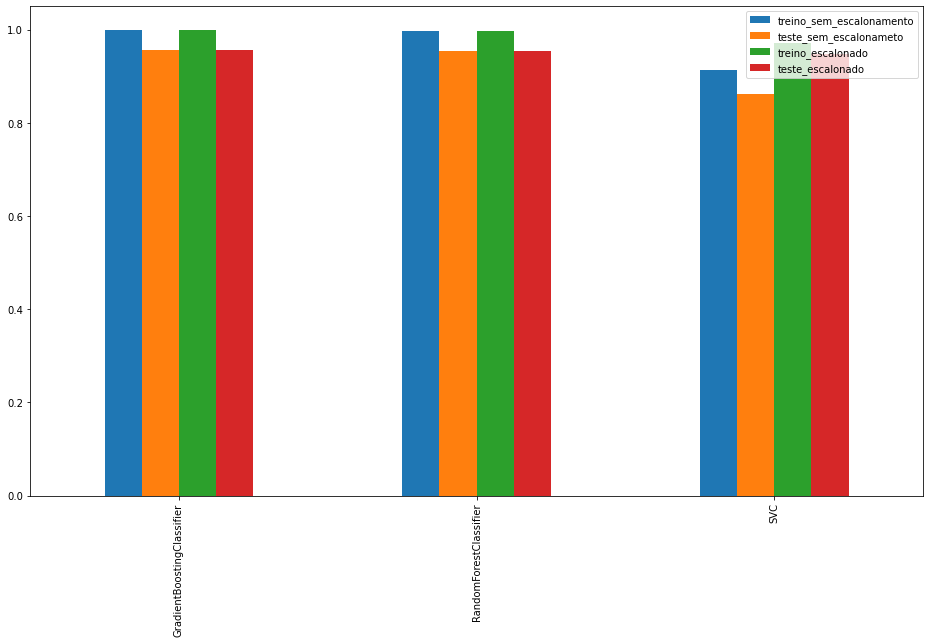

In [48]:
results.plot(kind='bar', figsize=(16,9))